<a href="https://colab.research.google.com/github/FaisalAhmed0/machine_learning_from_scratch/blob/main/policy_gradeints_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we implement policy gradient algorithm for discrete action spaces, specifically we implements the **REINFORCE** algorithm, which is basically trail and error learning

# Setup and imports

In [15]:
# This cell install a module for rendering a gym environment in colab
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender

Requirement already up-to-date: colabgymrender in /usr/local/lib/python3.7/dist-packages (1.0.8)


In [2]:
import gym # gym containt a training environemts to test our implementation 

# we wil use pytorch to create a train a nueral network policy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
import random
from colabgymrender.recorder import Recorder

from IPython.display import HTML
from base64 import b64encode

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3358720/45929032 bytes (7.3%)7069696/45929032 bytes (15.4%)10567680/45929032 bytes (23.0%)14581760/45929032 bytes (31.7%)18235392/45929032 bytes (39.7%)21995520/45929032 bytes (47.9%)25722880/45929032 bytes (56.0%)29270016/45929032 bytes (63.7%)32505856/45929032 bytes (70.8%)36413440/45929032 bytes (79.3%)40075264/45929032 bytes (87.3%)43188224/45929032 bytes (94.0%)

In [3]:
# use gpu if avaliable
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Fix the random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Function definitions

In [8]:
# function to generate samples from the environement using the policy
@torch.no_grad()
def generate_samples(env, policy, N, test=False):
  '''
  function to generate samples from the environement using the policy
  env: gym environemt object.
  policy: model of the policy that take a state as input and output an action.
  N: batch size.
  test: a boolean, if True it will run a random policy to test the function, otherwise it will use the policy model.
  return a batch, which is a tuple of (states, actions, rewards), with a list that contains the length of each episode in the batch.
  '''
  batch = None
  states = []
  actions = []
  rewards = []
  eps_length = []
  counter = 0
  while counter < N:
    done = False  
    new_episode = True
    length = 0
    while not done:
      if new_episode:
        state = env.reset()
        states.append(state)
        new_episode = False
      if test:
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
      else:
        action = policy(torch.unsqueeze(torch.tensor(state, dtype=torch.float32).to(device), dim=0))
        action_probs = F.softmax(action, dim=1)
        action = torch.multinomial(torch.squeeze(action_probs), 1) [0]
        state, reward, done, _ = env.step((action.cpu().item()))
      actions.append(action)
      rewards.append(reward)
      counter += 1
      length += 1
      if counter >= N:
        eps_length.append(length)  
        break
      if not done:
        states.append(state)
      if done:
        eps_length.append(length)  
  batch =  (torch.tensor(states, dtype=torch.float32), 
            torch.tensor(actions, dtype=torch.long), 
            torch.tensor(rewards, dtype=torch.float32), 
            )
  return batch, eps_length

In [9]:
def reward_to_go(rewards, gamma=0.99):
  '''
  function to compute the rewards to go
  rewards: a tensor containes the reward per time step
  gamma: discount factor
  '''
  T = len(rewards)
  reward_to_go = torch.zeros(T)
  for i in reversed(range(T)):
    reward_to_go[i] = rewards[i] + gamma * (reward_to_go[i+1] if i+1 < T else 0)
  return reward_to_go

In [10]:
def reward_baseline(rewards):
  return torch.mean(rewards)

In [11]:
def train(model, batch, critieria, optimizer, eps_lengths):
  '''
  train(model, batch, critieria, optimizer, eps_lengths)
  model: policy model.
  batch: bacth of trajectory data.
  critieria: the optimization loss.
  optimizer: model optimizer object.
  eps_lengths: a list containts the length of each episode in the batch.
  '''
  batch_size = len(batch[0])

  # variables for diganoses
  avg_reward = 0 # average reward per batch
  avg_length = 0 # average episode length per batch

  model.train()
  model = model.to(device)
  states, actions, rewards = batch
  # compute the reward to go
  rewards_to_go = torch.zeros(batch_size)
  start = 0
  for length in eps_length:
    reward_to_go_per_eps = reward_to_go(rewards[start:start+length])
    # print()
    # print(f"reward to go shape {reward_to_go_per_eps.shape}")
    # print(f"eps length {length}")
    # print(f" reward to go shape {rewards_to_go.shape}")
    rewards_to_go[start :start + length] = reward_to_go_per_eps
    start = length
  rewards_to_go = rewards_to_go.to(device)
  # compute the rewards baseline
  baseline = reward_baseline(rewards)
  # forward pass
  logits = model(states.to(device))
  # compute the policy loss
  loss = critieria(logits, actions.to(device))
  # print(loss.shape)
  loss *= (rewards_to_go.to(device) - baseline)
  # print(loss.shape)
  loss = loss.mean()
  # compute the mean loss
  # compute the gradient and update the policy parameters
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  start = 0
  for length in eps_length:
    avg_length += length
    avg_reward += rewards[start: start+length].sum()

  avg_reward /= len(eps_length)
  avg_length /= len(eps_length)
  return loss, avg_reward, avg_length 

# Model defintion

In [12]:
class Policy(nn.Module):
  def __init__(self, input_dim, action_dim):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, 64)
    self.linear2 = nn.Linear(64, 64)
    self.output = nn.Linear(64, action_dim)

  def forward(self, x):
    x =  F.relu(self.linear1(x))
    x =  F.relu(self.linear2(x))
    x = self.output(x)
    return x

# Training the agent

In [44]:
# Hyperparameters
lr = 3e-4
batch_size = 256
gamma = 0.99
iterations = range(3000)

In [45]:
# create the environment
env_name = "CartPole-v0"
env = gym.make(env_name)

In [46]:
# number of actions
env.action_space.n

2

In [47]:
# setup the model, loss function, and the optimizer
model = Policy(env.observation_space.shape[0], env.action_space.n)
model = model.to(device)
criteria = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=lr)

In [48]:
eps_length

[200, 200, 112]

In [49]:
# setup the training loop
losses = []
rs = []
ls = []
from tqdm import tqdm_notebook as tqdm
loop = tqdm(iterations)
for iter in loop:
  # sample from the environment
  batch, eps_length = generate_samples(env, model, batch_size)
  # train the agent 
  loss, avg_reward, avg_length = train(model, batch, criteria, optimizer, eps_length)
  rs.append(avg_reward)
  ls.append(avg_length)
  losses.append(loss.cpu().item())
  loop.set_description("Batch average Reward %0.2f" %avg_reward)

<Figure size 720x504 with 0 Axes>

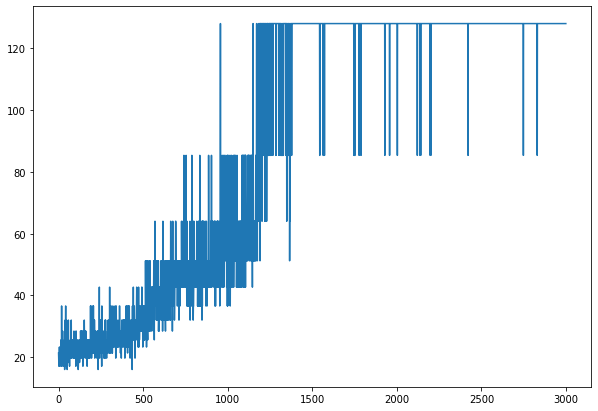

In [50]:
plt.figure(figsize=(10, 7))
plt.plot(rs)

In [52]:
# test the agent
done = False
new_episode = True
rewards = 0
env = gym.make(env_name)
env = Recorder(env, "./")
while not done:
  if new_episode:
    state = env.reset()
    # states.append(state)
    new_episode = False
  action = model(torch.unsqueeze(torch.tensor(state, dtype=torch.float32).to(device), dim=0))
  action_probs = F.softmax(action, dim=1)
  action = torch.argmax(action_probs)
  state, reward, done, _ = env.step((action.cpu().item()))
  rewards += 1
print()
print(f"Total rewards {rewards}")
env.play()

  0%|          | 0/201 [00:00<?, ?it/s]


Total rewards 200


100%|██████████| 201/201 [00:00<00:00, 377.85it/s]
